In [1]:
from pathlib import Path
from typing import Tuple, Optional
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import random

# plt.style.use(snakemake.params.style)
# sns.set_palette(snakemake.params.palette)
# FIGSIZE = snakemake.params.figsize
# DPI = snakemake.params.dpi
plt.style.use("ggplot")
sns.set_palette("Set1")
FIGSIZE = (13, 8)
DPI = 300

In [3]:
def draw(
    data: pd.DataFrame, 
    x: str, 
    y: str, 
    title: str,
    xtitle: Optional[str] = None,
    ytitle: Optional[str] = None,
    hue: Optional[str] = None, 
    ylim: Optional[Tuple[int, int]] = None
):
    fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
    sns.boxenplot(
        x=x, 
        y=y, 
        hue=hue, 
        data=data, 
    )
    
    if ylim:
        ax.set_ylim(ylim)
        
    ax.set_title(title)
    
    if xtitle:
        ax.set_xlabel(xtitle)
        
    if ytitle:
        ax.set_ylabel(ytitle)
        
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', linewidth=0.75, alpha=1.0)
    ax.grid(b=True, which='minor', linewidth=0.5, alpha=0.5)
        
    return fig, ax

# Read BLAST identity

In [4]:
# read_identity_files = snakemake.input.read_identity_csvs
evaluation_dir = Path("../results/evaluation")
read_identity_files = list(evaluation_dir.rglob("*.read_identity.csv"))
print(f"{len(read_identity_files)} CSV files")

16 CSV files


In [5]:
frames = []
for csvfile in read_identity_files:
    df = pd.read_csv(csvfile)
    sample, model = csvfile.name.split(".")[:2]
    df["sample"] = sample
    df["model"] = model
    frames.append(df)
data = pd.concat(frames)

Here we plot the [BLAST identity][blast] for each read. Each sample has been grouped together into one violin plot per basecalling model. To get the BLAST identity, we basecalled the reads with the respective model and mapped those basecalls to the "truth" assembly. To calculate the BLAST identity for each mapping, we take the number of matching bases divided by the length of the alignment. For more information, refer to [this][pafpy-blast] implementation.  

The Y-axis of the plot has been "zoomed in" to get a better sense of how the models compare.

[blast]: https://lh3.github.io/2018/11/25/on-the-definition-of-sequence-identity#blast-identity
[pafpy-blast]: https://pafpy.xyz/pafrecord.html#pafpy.pafrecord.PafRecord.blast_identity

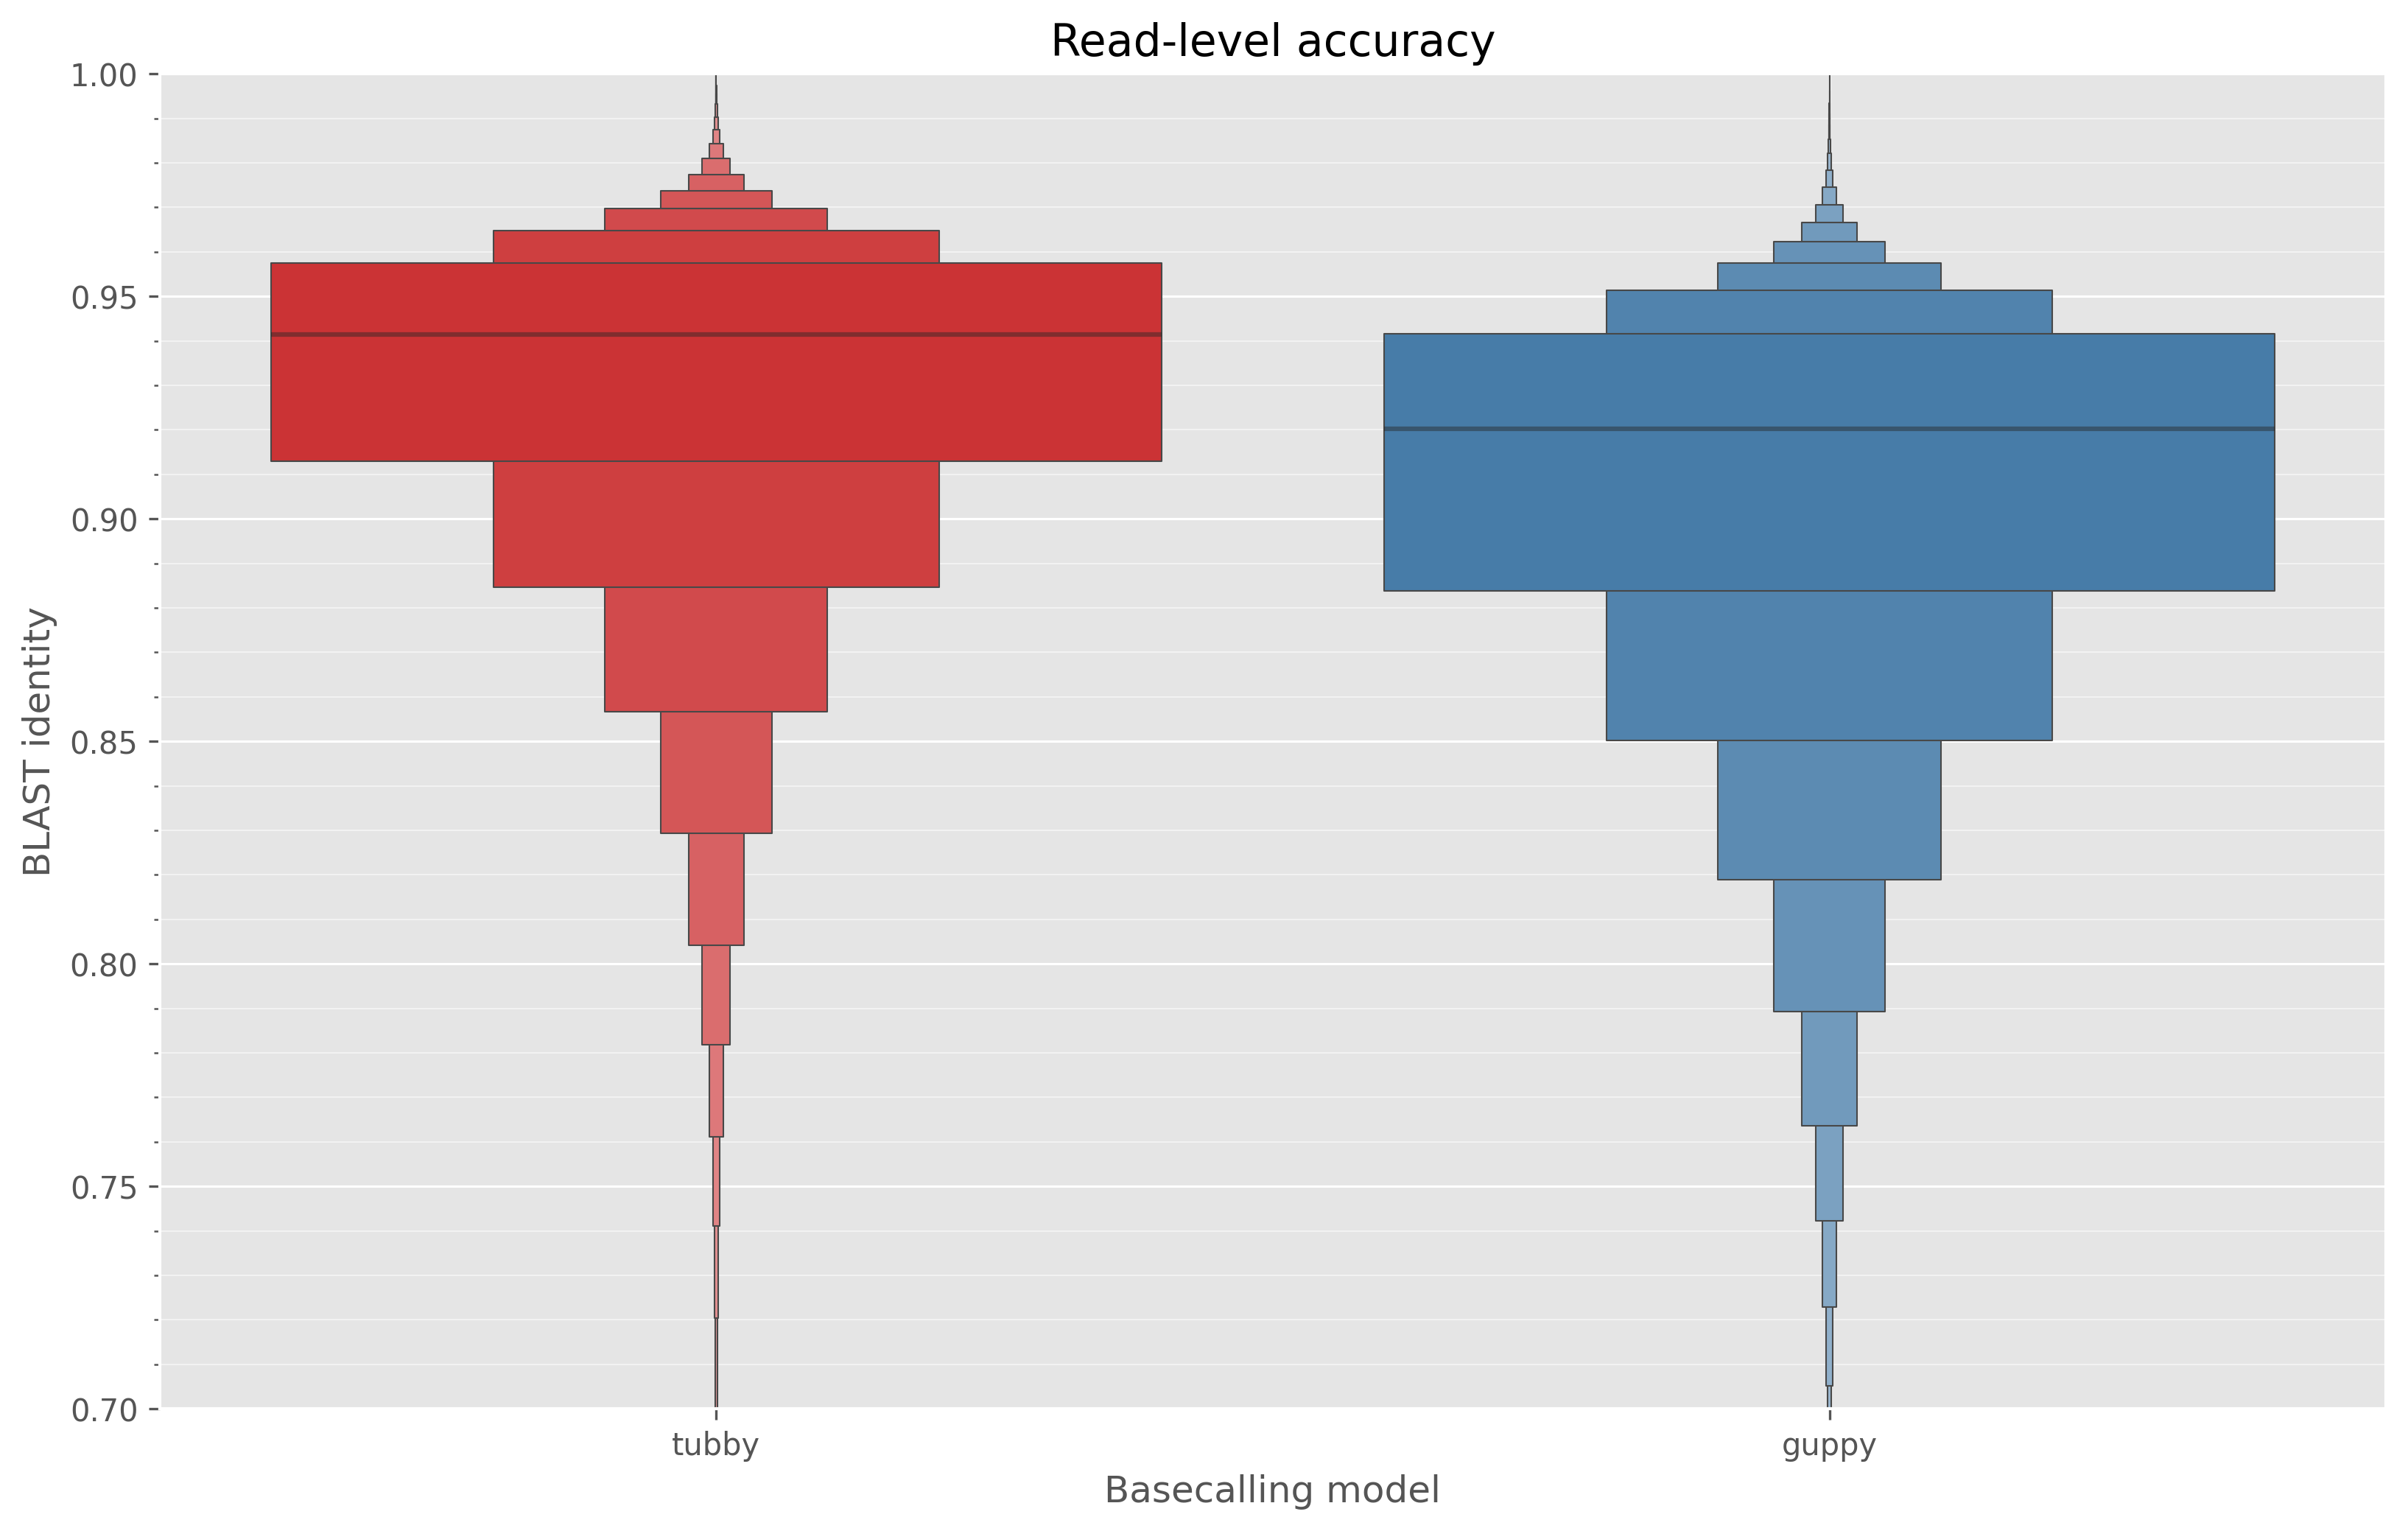

In [6]:
title = "Read-level accuracy"
xtitle = "Basecalling model"
ytitle = "BLAST identity"
ylim = (0.7, 1.0)
x = "model"
y = "identity"
fig, ax = draw(data, x=x, y=y, ylim=ylim, title=title, xtitle=xtitle, ytitle=ytitle)

In [101]:
fig.savefig(snakemake.output.read_identity)

## Summary statistics

In [7]:
data.groupby("model")["identity"].describe()

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
guppy,1047829.0,0.906699,0.048019,0.418569,0.883826,0.920168,0.941614,1.0
tubby,1047508.0,0.929516,0.040221,0.461869,0.912879,0.941470,0.957413,1.0


# Relative read length

We define relative read length as the length of the *aligned* part of the read, divided by the total length of the read. The purpose of this metric is to see whether there is a bias towards insertions (greater than 1.0) or deletions (less than 1.0).

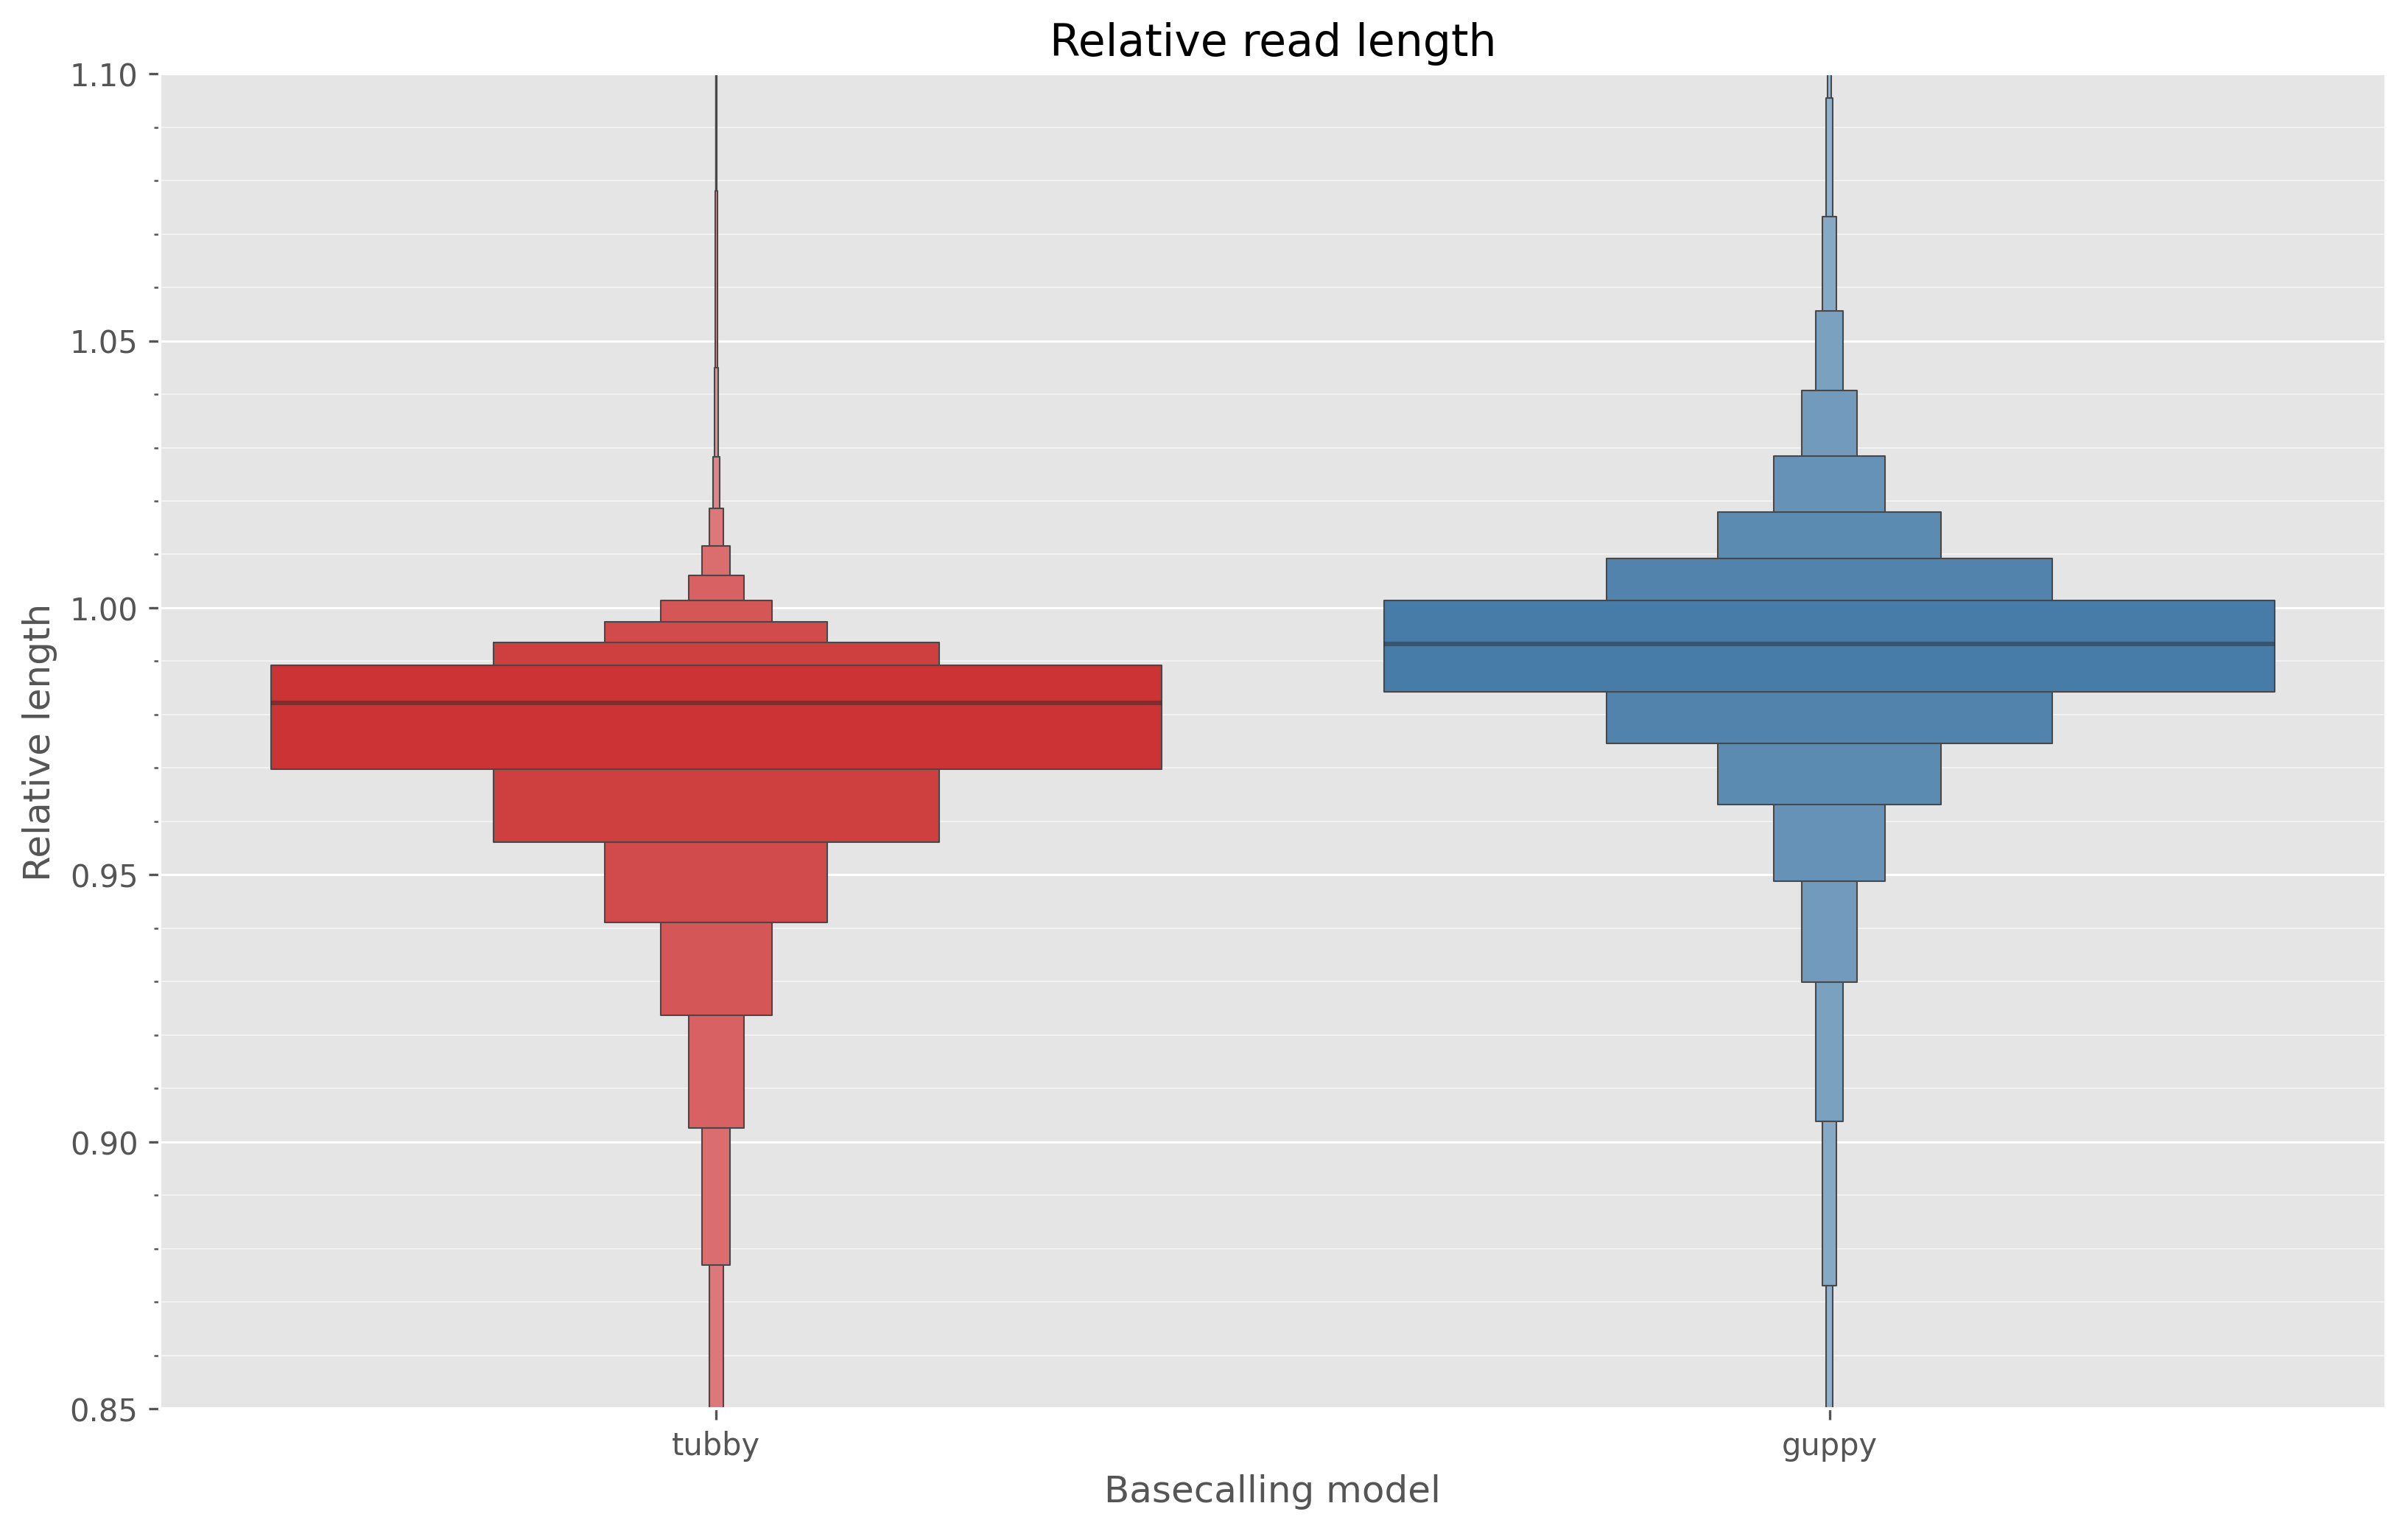

In [8]:
title = "Relative read length"
xtitle = "Basecalling model"
ytitle = "Relative length"
ylim = (0.85, 1.1)
fig, ax = draw(data, x="model", y="relative_len", ylim=ylim, title=title, xtitle=xtitle, ytitle=ytitle)

In [ ]:
fig.savefig(snakemake.output.read_relative_len)

## Summary statistics

In [9]:
data.groupby("model")["relative_len"].describe()

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
guppy,1047829.0,0.991860,0.023972,0.455827,0.984218,0.993194,1.001440,1.988124
tubby,1047508.0,0.976374,0.023877,0.493556,0.969833,0.982176,0.989214,1.894910


# Read length against read identity

In [48]:
N = snakemake.params.subsample
sub_df = data.iloc[random.sample(range(len(data)), N)]

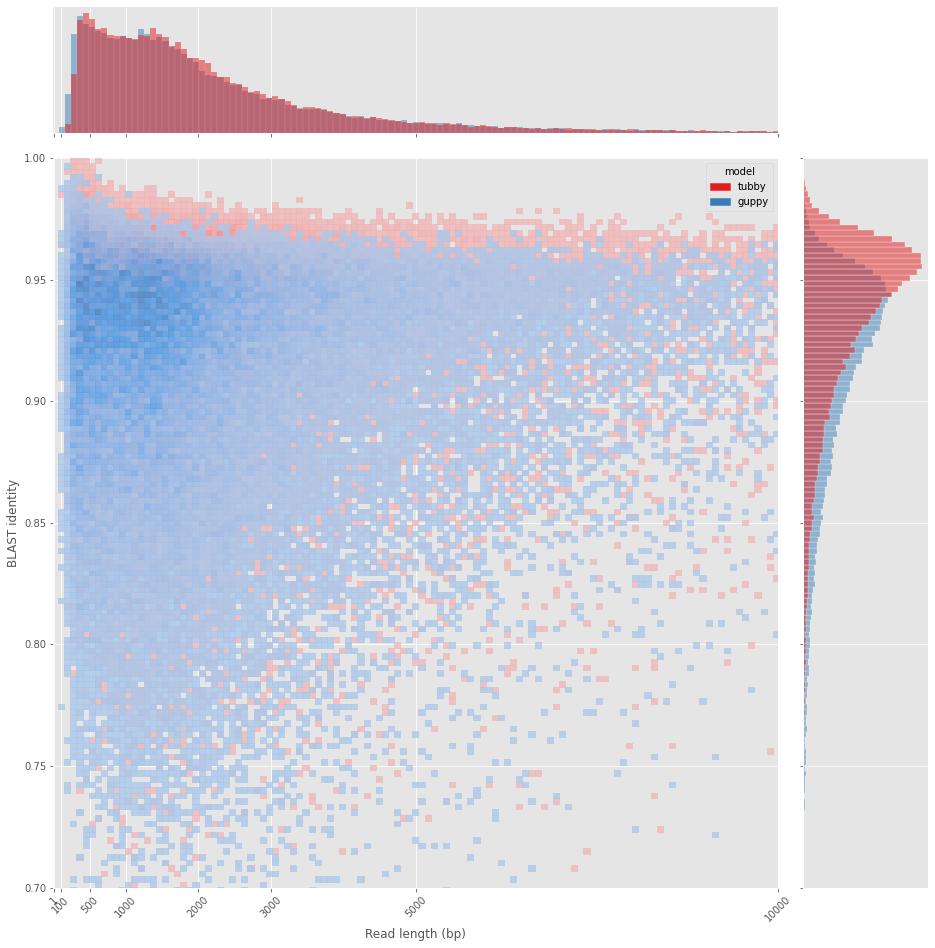

In [51]:
x = "read_len"
xtitle = "Read length (bp)"
y = "identity"
ytitle = "BLAST identity"
title = "Read length against identity"

log_ticks = [1, 100, 500, 1e3, 2e3, 3e3, 5e3, 1e4]
xlim = (0, log_ticks[-1])
ylim = (0.7, 1.0)

jplot = sns.jointplot(
    data=sub_df,
    x=x, 
    y=y, 
    hue="model",
    kind="hist",
    alpha=0.8, 
    height=FIGSIZE[0],
)
_ = jplot.ax_joint.set(xticks=log_ticks, xlim=xlim, ylabel=ytitle, xlabel=xtitle, ylim=ylim)
_ = plt.xticks(rotation=45)

In [ ]:
jplot.savefig(snakemake.output.read_identity_vs_len, dpi=DPI)

# Consensus accuracy
Here we show consensus accuracy in a similar manner to read identity. Each "read" in this context is a result of chopping the [`rebaler`](https://github.com/rrwick/Rebaler) assembly of the reads up into 10Kbps "chunks" to simulate reads, and then mapping those chunks back to the original assembly using `minimap2` (and the `-x asm5` preset).

In [11]:
# consensus_identity_files = snakemake.input.consensus_identity_csvs
consensus_identity_files = list(evaluation_dir.rglob("*.consensus_identity.csv"))
print(f"{len(consensus_identity_files)} CSV files")

16 CSV files


In [12]:
frames = []
for csvfile in consensus_identity_files:
    df = pd.read_csv(csvfile)
    sample, model = csvfile.name.split(".")[:2]
    df["sample"] = sample
    df["model"] = model
    df["type"] = "consensus"
    frames.append(df)

data = pd.concat(frames)

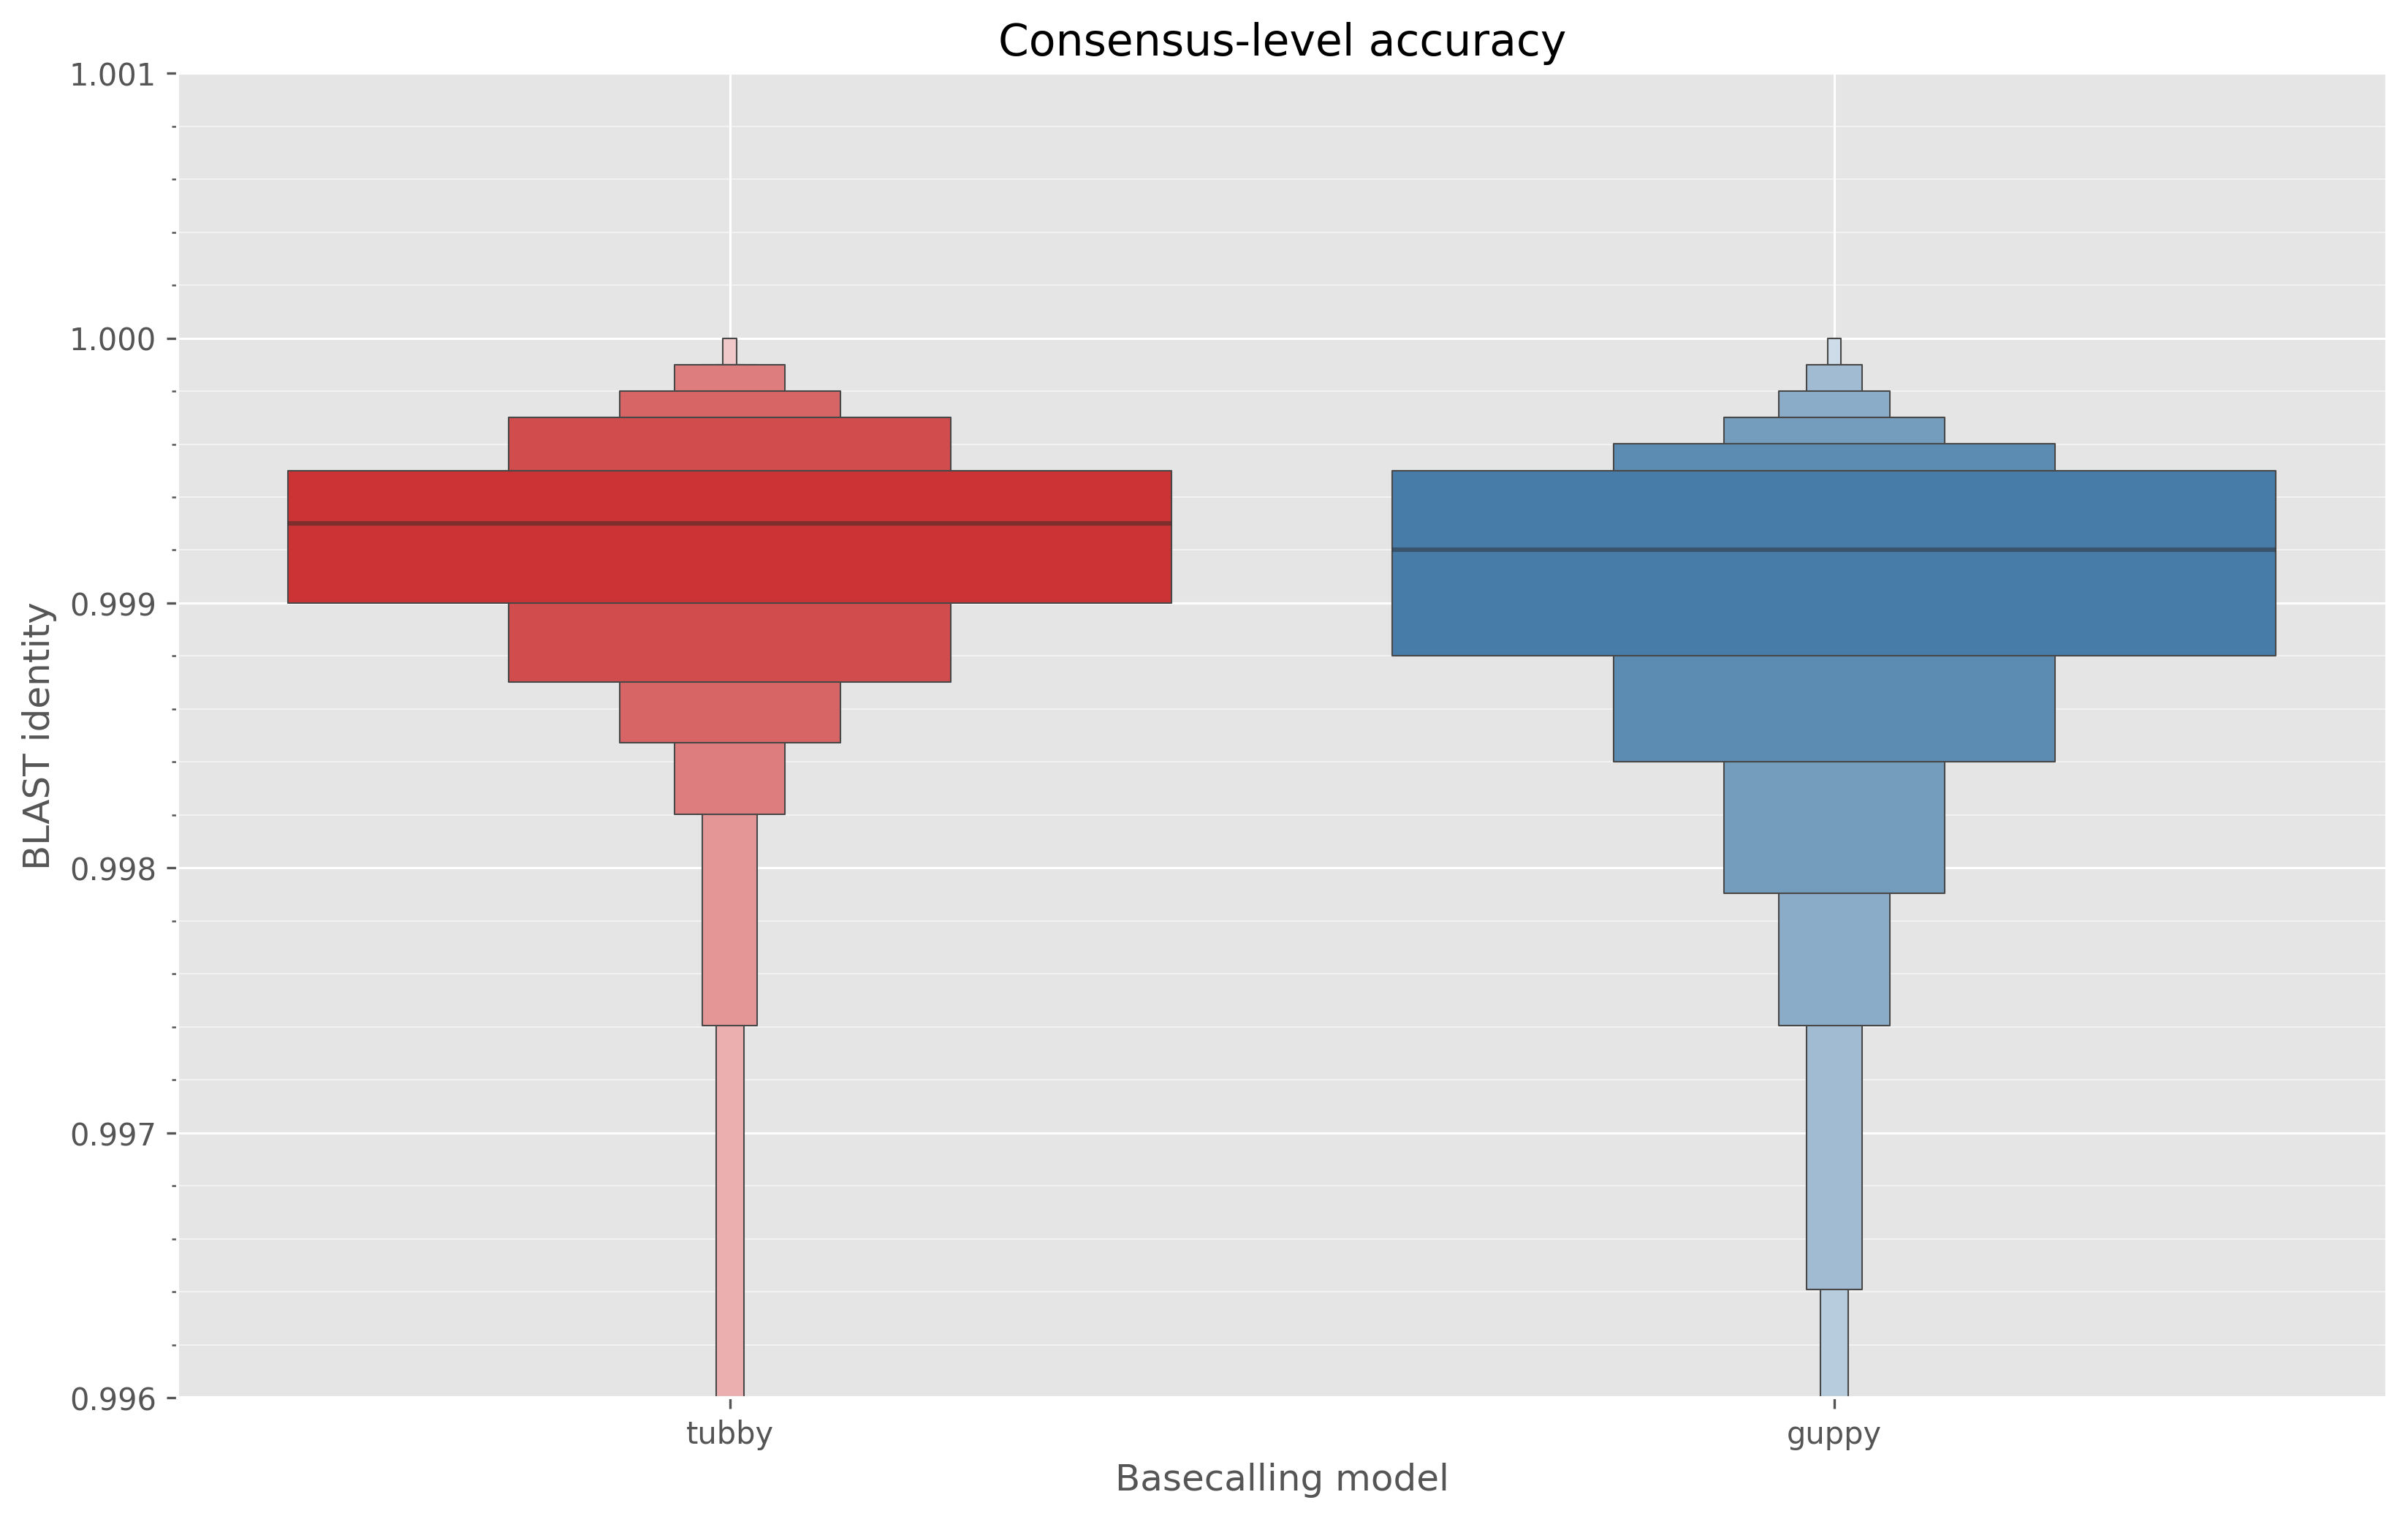

In [17]:
title = "Consensus-level accuracy"
xtitle = "Basecalling model"
ytitle = "BLAST identity"
ylim = (0.996, 1.001)
x = "model"
y = "identity"
fig, ax = draw(data, x=x, y=y, ylim=ylim, title=title, xtitle=xtitle, ytitle=ytitle)

In [ ]:
fig.savefig(snakemake.output.consensus_identity)

### Summary statistics

In [19]:
data.groupby(x)[y].describe()

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
guppy,3531.0,0.998735,0.004426,0.863455,0.998801,0.9992,0.9995,1.0
tubby,3532.0,0.998971,0.004102,0.862996,0.999001,0.9993,0.9995,1.0


# Relative "read" length for consensus chunks

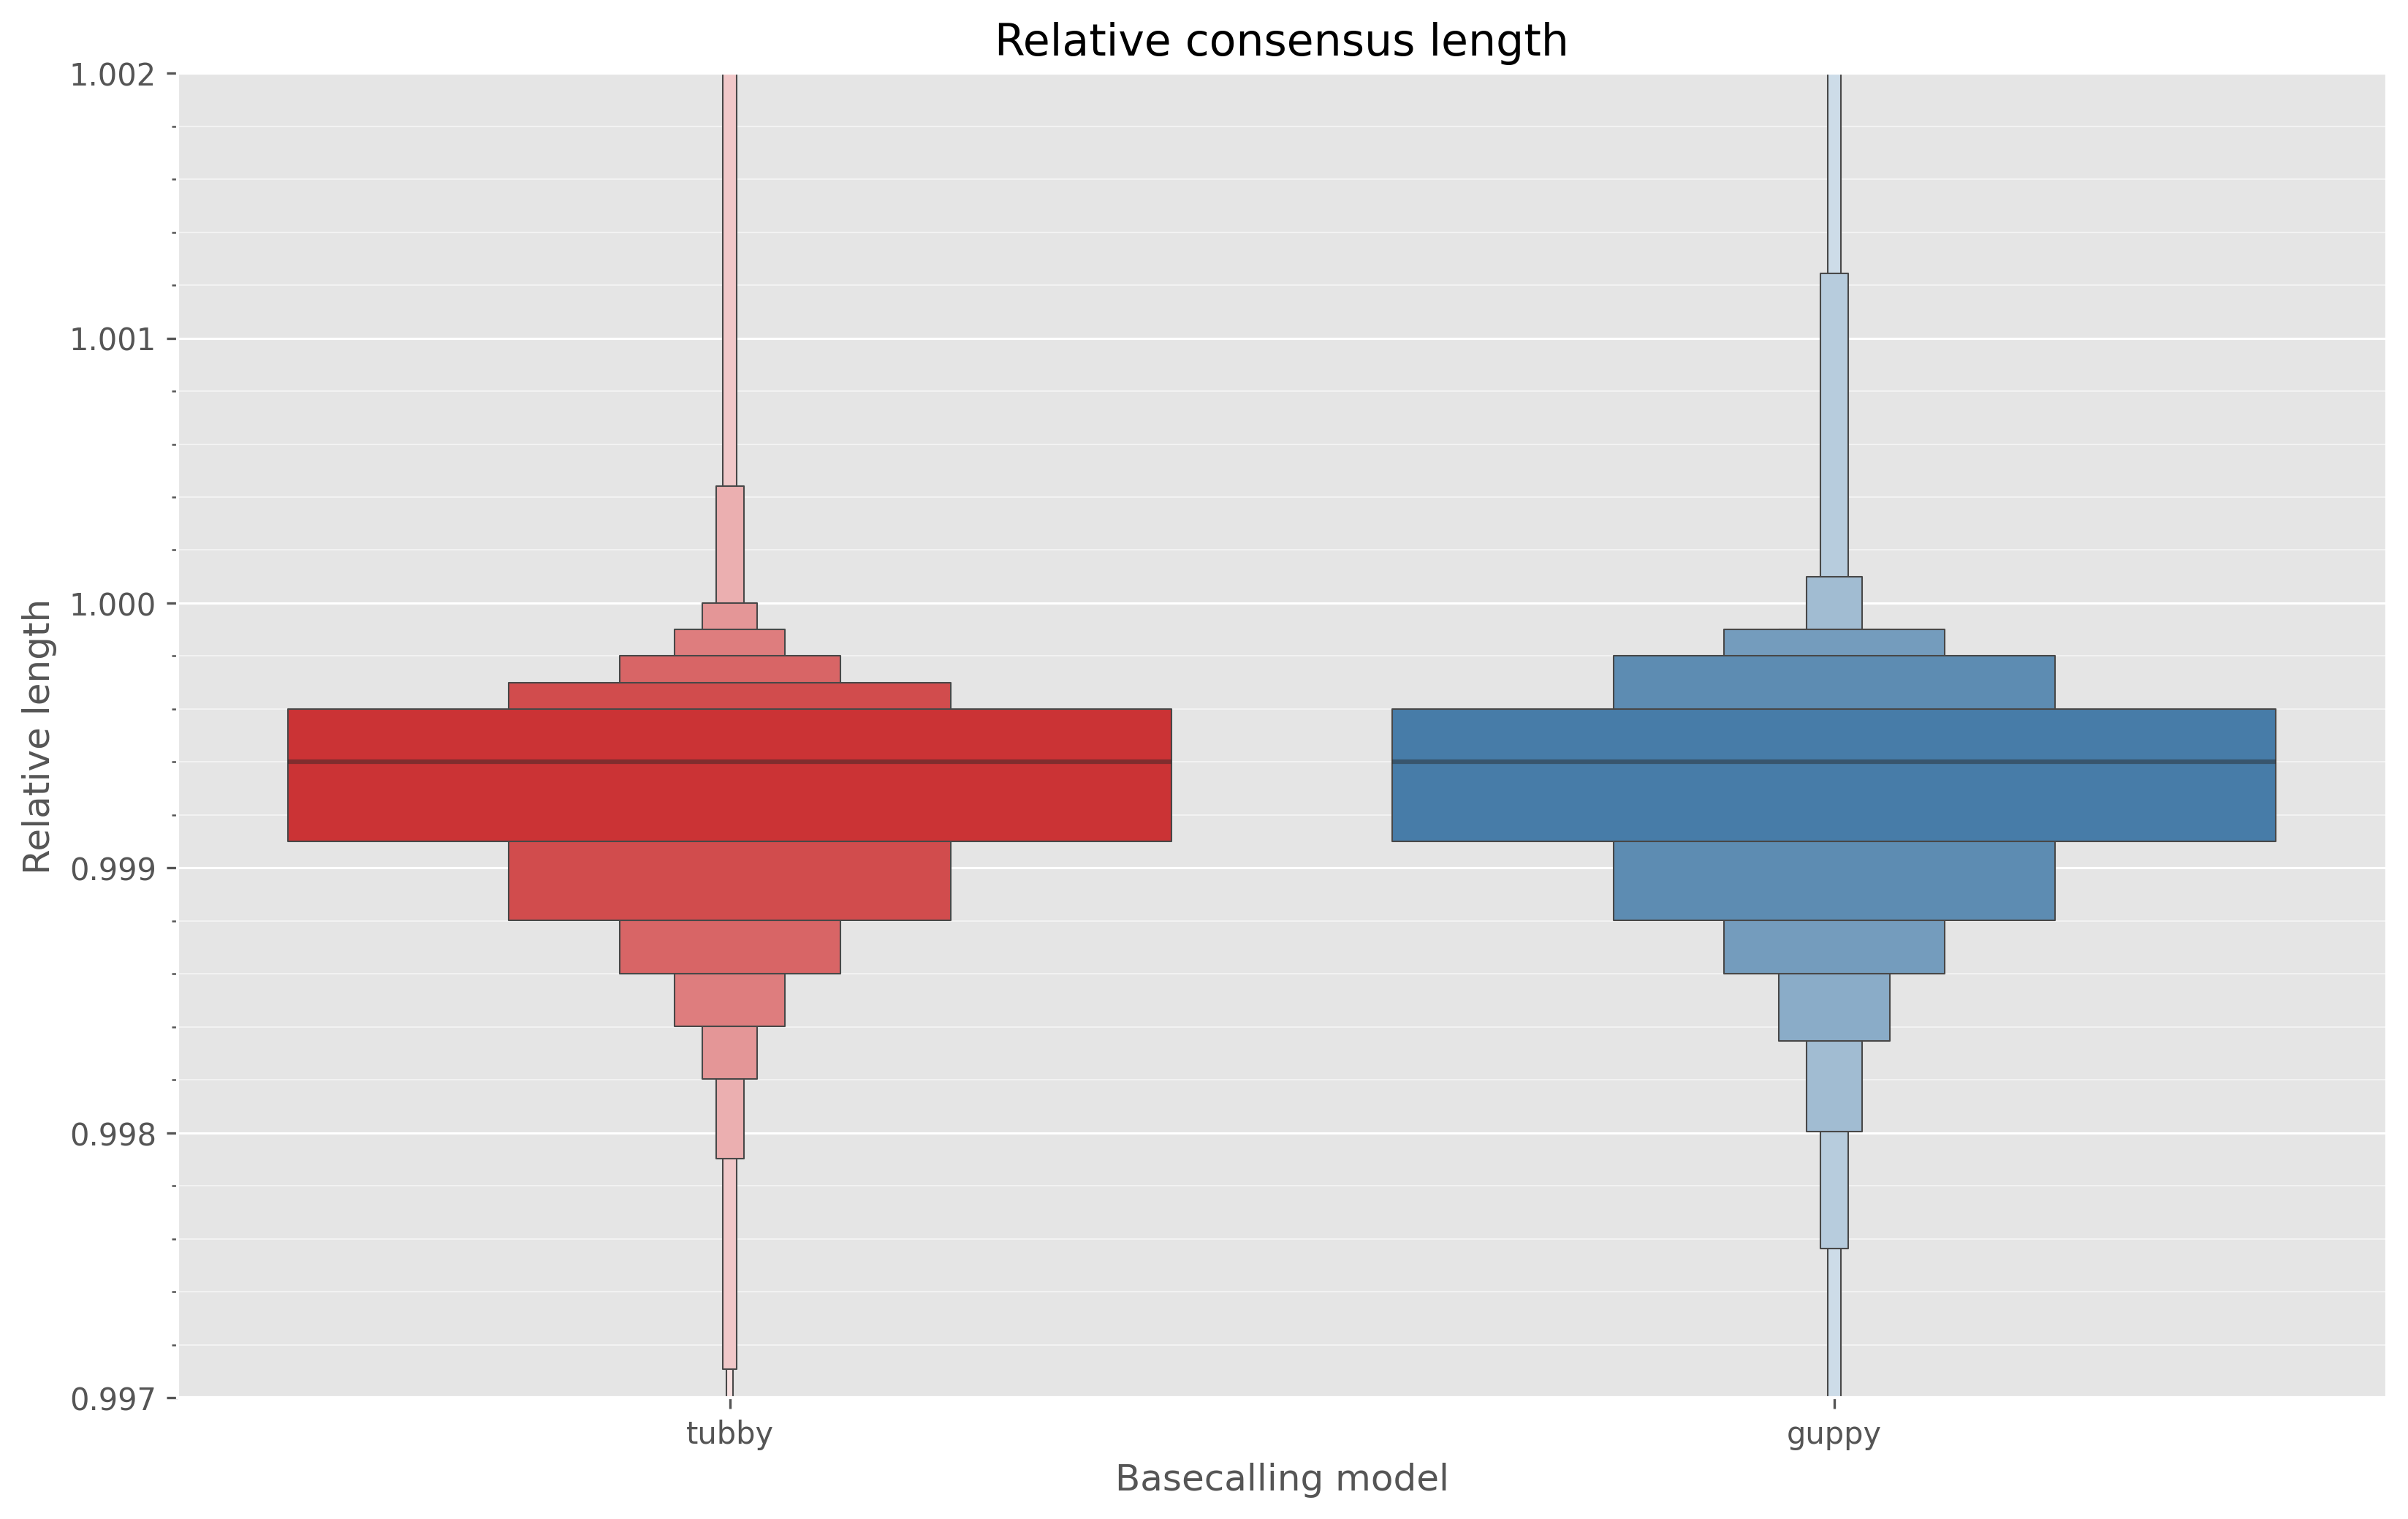

In [24]:
title = "Relative consensus length"
xtitle = "Basecalling model"
ytitle = "Relative length"
ylim = (0.997, 1.002)
fig, ax = draw(data, x="model", y="relative_len", ylim=ylim, title=title, xtitle=xtitle, ytitle=ytitle)

In [ ]:
fig.savefig(snakemake.output.consensus_relative_len)

### Summary statistics

In [25]:
data.groupby(x)[y].describe()

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
guppy,3531.0,0.998735,0.004426,0.863455,0.998801,0.9992,0.9995,1.0
tubby,3532.0,0.998971,0.004102,0.862996,0.999001,0.9993,0.9995,1.0


# Consensus error types
Here we classify the types of errors that occur in the assemblies and look at how these errors compare across models. The errors are per-assembly, so the confidence intervals represent to variation in error types between samples/assemblies.

In [26]:
# error_files = snakemake.input.asm_error_tsvs
error_files = list(evaluation_dir.rglob("*.assembly_error_details.tsv"))
print(f"{len(error_files)} TSV files")

16 TSV files


In [27]:
frames = []
for csvfile in error_files:
    df = pd.read_csv(csvfile, sep="\t")
    sample, model = csvfile.name.split(".")[:2]
    df["sample"] = sample
    df["model"] = model
    df["type"] = "consensus"
    frames.append(df)

id_vars = ["sample", "model", "type", "assembly"]
value_vars = ["dcm", "homo_del", "homo_ins", "other_del", "other_ins", "sub"]
data = pd.concat(frames).melt(id_vars=id_vars, value_vars=value_vars, var_name="error_type")

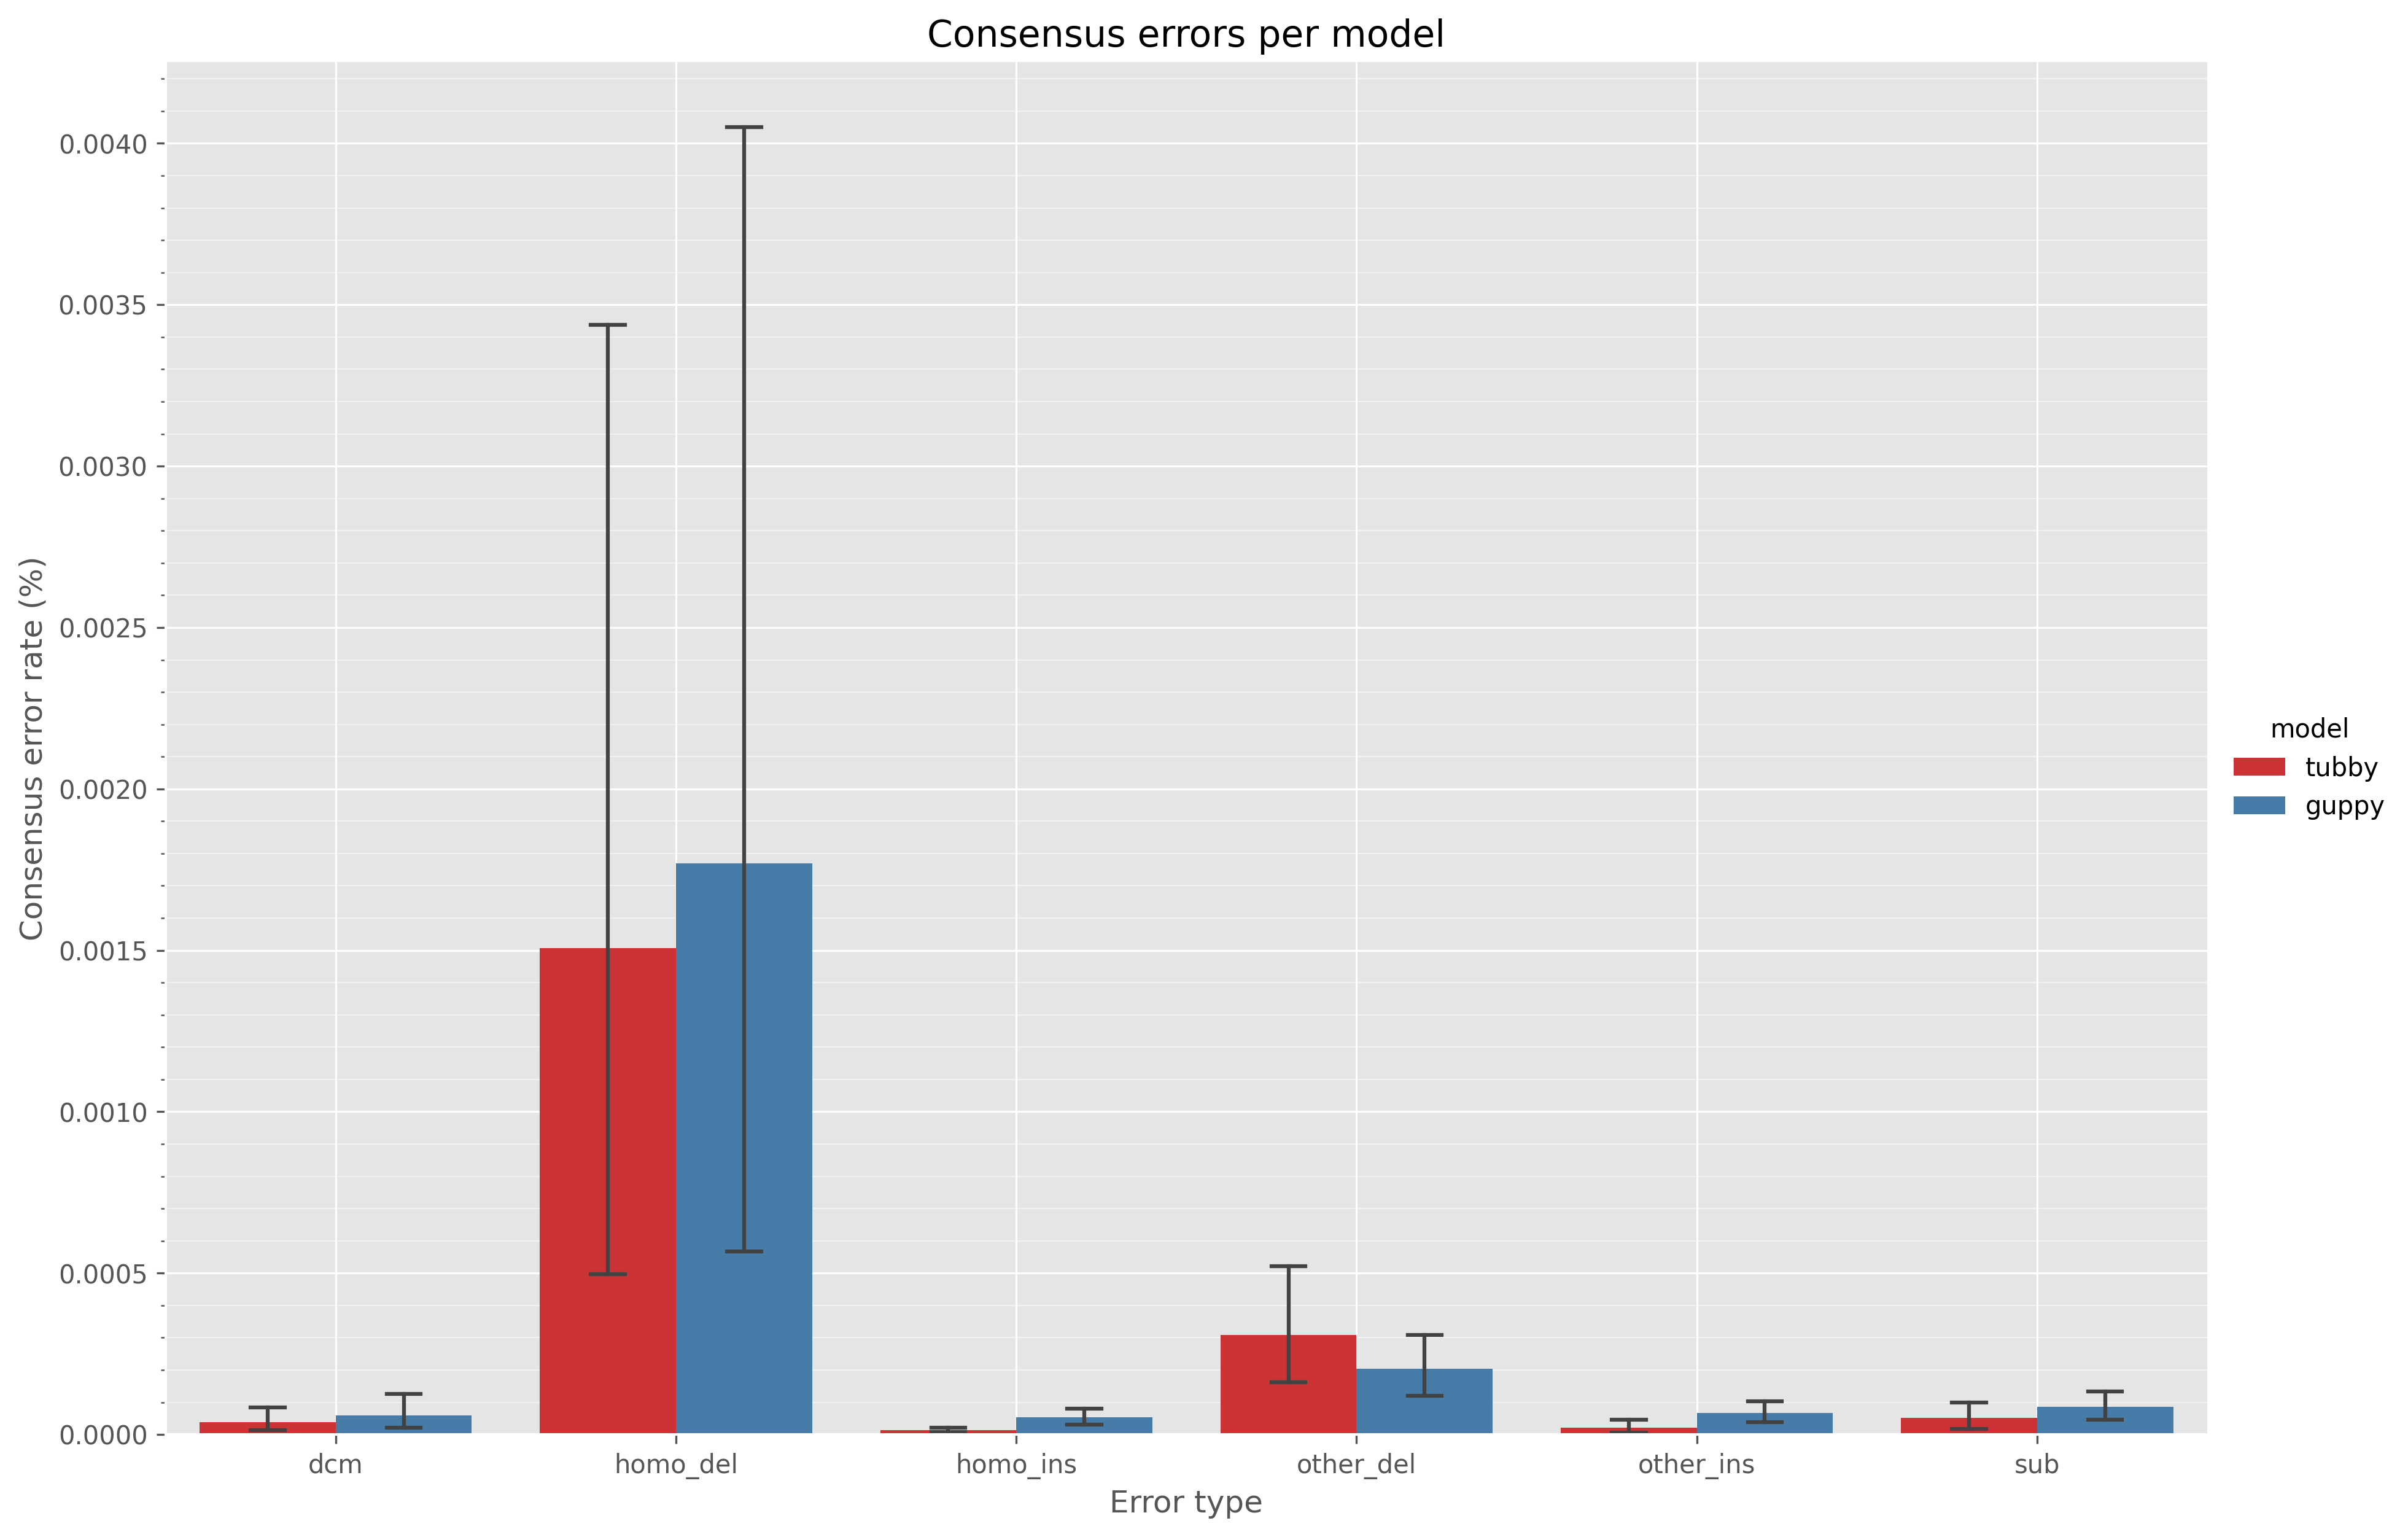

In [32]:
x = "error_type"
y = "value"
hue = "model"
kind = "bar"
plot = sns.catplot(
    data=data, 
    x=x, 
    y=y, 
    hue=hue, 
    kind=kind, 
    height=8, 
    aspect=1.5, 
    errwidth=1.5, 
    capsize=0.1
)
plot.set_xlabels("Error type")
plot.set_ylabels("Consensus error rate (%)")
plot.set(title="Consensus errors per model")
plot.ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
plot.ax.grid(b=True, which='major', linewidth=0.75)
plot.ax.grid(b=True, which='minor', linewidth=0.5, alpha=0.5)
plot.fig.set_dpi(DPI)

In [ ]:
plot.fig.savefig(snakemake.output.error_types)